# Modelado v1.2
---

En este notebook, vamos a seguir el mimso enfoque que en la anterior versión, pero utilizaremos unos datos de entrada que incluyan **sólo features relativas a si un alumno entregó o no las actividades de evaluación continua**, no los cuestionarios, 

In [51]:
# Core
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

# Modelado
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (f1_score, roc_auc_score,
                                           precision_score, recall_score,
                                           make_scorer)
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from scikeras.wrappers import KerasClassifier

# Desbalance
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

from tensorflow import keras
from tensorflow.keras.optimizers import Adam

import joblib, os

#----------Rutas de los datos----------
DATA_PATH = '/home/carlos/Documentos/TFG/spark-workspace/data/datasets/'

# --- Carpeta donde guardaremos los modelos entrenados ---
MODEL_PATH = "models_v1.2"
os.makedirs(MODEL_PATH, exist_ok=True)


## Carga de datos 

In [52]:
# 1. Carga y filtrado de columnas

df = pd.read_parquet(f"{DATA_PATH}/dataset_2.0.parquet")

# Nos quedamos sólo con las columnas de entregas (quitamos notas y cuestionarios)
df = df.loc[:, ~df.columns.str.startswith("Clase")]
df = df.loc[:, ~df.columns.str.contains(r"\(nota\)")]
df = df.drop(columns=["num_entregas"], errors="ignore")

# 2. Recalcular num_entregas: 
#    suma de todas las columnas binarias de entregas (0/1) por fila
cols_actividades = [c for c in df.columns if c not in ["userid", "abandona"]]
df["num_entregas"] = df[cols_actividades].sum(axis=1)

# 3. Guardar el nuevo DataFrame
df.to_parquet(f"{DATA_PATH}/dataset_2.1.parquet")

# 4. Separar X / y
X = df.drop(columns=["userid", "abandona"])
y = df["abandona"]

display(df.head(3))
print("X shape:", X.shape)
print(X.info())


,userid,Test Expr.,Test Complejidad,Act. 02 - Elecciones,Act. 03 - Catalan,Act. 04 - Primos,Act. 05 - Vectores,Act. 07,abandona,num_entregas
0,e1f1d0f48ca77093f9d66cefd325504245277db3e6c145...,1,1,1,1,1,0,1,0,6
1,b5de2bb5b8538b199d6b3f0ecb32daa8a9d730ccc484db...,1,1,1,1,1,1,1,0,7
2,90a634296aff946e9d045997d512d2b77dbc01880715c1...,1,1,1,1,1,1,1,1,7


X shape: (201, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201 entries, 0 to 200
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   Test Expr.            201 non-null    int32
 1   Test Complejidad      201 non-null    int32
 2   Act. 02 - Elecciones  201 non-null    int32
 3   Act. 03 - Catalan     201 non-null    int32
 4   Act. 04 - Primos      201 non-null    int32
 5   Act. 05 - Vectores    201 non-null    int32
 6   Act. 07               201 non-null    int32
 7   num_entregas          201 non-null    int64
dtypes: int32(7), int64(1)
memory usage: 7.2 KB
None


## Definir pipeline de los modelos tradicionales

In [53]:


# --- Preprocesador único: escala num_entregas, pasa el resto sin cambios ---
preprocessor = ColumnTransformer(
    [("scale_num_entregas", StandardScaler(), ["num_entregas"])],
    remainder="passthrough"
)

def make_pipeline(name: str, use_smote: bool):
    """
    Devuelve (pipeline, ruta_a_guardar) según el nombre del modelo y si aplicamos SMOTE.
    Todos usan el mismo 'preprocessor'.
    """
    # Selección de clasificador base
    if name == "LogReg":
        clf = LogisticRegression(class_weight="balanced", max_iter=1000)
    elif name == "Tree":
        clf = DecisionTreeClassifier(class_weight="balanced", random_state=42)
    elif name == "XGB":
        ratio = (y == 0).sum() / (y == 1).sum()
        clf = XGBClassifier(
            n_estimators=200, max_depth=4, learning_rate=0.05,
            subsample=0.8, colsample_bytree=0.8,
            eval_metric="logloss",
            scale_pos_weight=y.value_counts()[0] / y.value_counts()[1],
            random_state=42
        )
    else:
        raise ValueError(f"Modelo desconocido: {name}")

    # Montamos el pipeline
    steps = [("pre", preprocessor)]
    if use_smote:
        steps.append(("smote", SMOTE()))
    steps.append(("clf", clf))

    pipe = ImbPipeline(steps) if use_smote else Pipeline(steps)

    # Definimos nombre de fichero donde guardarlo
    suffix = "_smote" if use_smote else ""
    fname  = os.path.join(MODEL_PATH, f"{name.lower()}{suffix}.pkl")
    return pipe, fname


## Evaluación + guardado de los 3 modelos “tradicionales”

In [54]:
# ============================================================
# 1) Cross-validation, métricas y guardado de modelos clásicos
# ============================================================
import os, joblib
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_validate


scoring = ["f1", "roc_auc", "precision", "recall"]

def evaluate_and_save(name: str, use_smote: bool = False):
    """
    - Ejecuta CV estratificada (5 folds) con las métricas de interés.
    - Re-entrena el pipeline con TODO el dataset.
    - Guarda el pipeline en disco.
    - Devuelve un dict con medias ± std de las métricas y la ruta al .pkl.
    """
    pipe, fname = make_pipeline(name, use_smote)
    cvres = cross_validate(
        pipe, X, y, cv=5, scoring=scoring, return_train_score=False
    )
    metrics = {m: (cvres[f"test_{m}"].mean(), cvres[f"test_{m}"].std())
               for m in scoring}

    # Reentrenamos sobre X, y completos y almacenamos
    pipe.fit(X, y)
    joblib.dump(pipe, fname)

    return {"model": f"{name}{'+SMOTE' if use_smote else ''}", "file": fname, **metrics}

# Ejecutamos para LR, Árbol y XGB (con y sin SMOTE)
results = []
for mdl in ["LogReg", "Tree", "XGB"]:
    results.append(evaluate_and_save(mdl, use_smote=False))
    results.append(evaluate_and_save(mdl, use_smote=True))

# Construir DataFrame de métricas
rows = []
for r in results:
    row = {"model": r["model"]}
    for m in scoring:
        mean, std = r[m]
        row[m] = f"{mean:.3f} ± {std:.3f}"
    rows.append(row)

res_df = pd.DataFrame(rows).set_index("model")
display(res_df)


,f1,roc_auc,precision,recall
model,,,,
LogReg,0.610 ± 0.136,0.842 ± 0.063,0.519 ± 0.122,0.757 ± 0.195
LogReg+SMOTE,0.575 ± 0.116,0.816 ± 0.097,0.479 ± 0.110,0.733 ± 0.160
Tree,0.468 ± 0.169,0.660 ± 0.201,0.385 ± 0.134,0.610 ± 0.244
Tree+SMOTE,0.404 ± 0.147,0.682 ± 0.214,0.476 ± 0.178,0.367 ± 0.153
XGB,0.473 ± 0.116,0.750 ± 0.115,0.380 ± 0.080,0.638 ± 0.190
XGB+SMOTE,0.491 ± 0.125,0.714 ± 0.182,0.391 ± 0.085,0.671 ± 0.206


 ## Cross-validation de la Red Neuronal (solo métricas + curva de AUC por época)

In [55]:
# ============================================================
# CV de la Red Neuronal con/sin SMOTE (5 folds, DataFrame)
# ============================================================
import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_validate
from scikeras.wrappers import KerasClassifier
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

# --- 1) Construcción del wrapper Keras idéntico al de Modelado.py ----
def build_model(meta, units=64, dr=0.3):
    n_features = meta["n_features_in_"]
    model = Sequential([
        Dense(units, activation="relu", input_shape=(n_features,)),
        Dropout(dr),
        Dense(units // 2, activation="relu"),
        Dense(1, activation="sigmoid")
    ])
    model.compile(
        optimizer=Adam(1e-3),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    return model

ratio = y.value_counts()[0] / y.value_counts()[1]
nn_clf = KerasClassifier(
    model=build_model,
    epochs=60,
    batch_size=16,
    verbose=0,
    fit__class_weight={0: 1, 1: ratio},
    random_state=42
)

# --- 2) Pipelines: sin SMOTE y con SMOTE --------------------------
pipe_no = Pipeline([
    ("pre", preprocessor),
    ("nn",  nn_clf)
])
pipe_sm = ImbPipeline([
    ("pre",   preprocessor),
    ("smote", SMOTE()),
    ("nn",    nn_clf)
])

# --- 3) Cross‐validation para ambos ----------------------------------
cv      = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = ["f1", "roc_auc", "precision", "recall"]

results = {}
for name, pipe in [("NN", pipe_no), ("NN+SMOTE", pipe_sm)]:
    cvres = cross_validate(
        pipe, X, y,
        cv=cv,
        scoring=scoring,
        n_jobs=-1
    )
    # guardar mean/std de cada métrica
    results[name] = {
        m: (cvres[f"test_{m}"].mean(), cvres[f"test_{m}"].std())
        for m in scoring
    }

# --- 4) Montar DataFrame final ---------------------------------------
df = pd.DataFrame({
    name: {metric: f"{mean:.3f} ± {std:.3f}"
           for metric, (mean, std) in mets.items()}
    for name, mets in results.items()
})

# --- 5) Mostrar resultados ------------------------------------------
print("Neural Network – 5-fold CV (métricas mean ± std)")
display(df)


2025-06-20 20:46:50.980364: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750445210.999510  188577 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750445211.004967  188577 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750445211.019692  188577 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750445211.019725  188577 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750445211.019728  188577 computation_placer.cc:177] computation placer alr

Neural Network – 5-fold CV (métricas mean ± std)


,NN,NN+SMOTE
f1,0.543 ± 0.046,0.534 ± 0.034
roc_auc,0.826 ± 0.066,0.748 ± 0.049
precision,0.461 ± 0.067,0.416 ± 0.038
recall,0.690 ± 0.115,0.757 ± 0.074


## Primeras conclusiones

Los resultados de estos modelos los cuales utilizan el nuevo dataset creado son realmente sorprendentes, dado que varían mucho respecto a los del anterior dataset. En ese, el que mejor rendimiento general ofrecía con diferencia era XGBoost, sin embargo, aquí lo es la regresión logística. Quizás sea la que más se ha beneficiado de la reducción de features, dado que puede capturar mejor patrones lineales en los datos cuando hay menos características. El recall es muy bueno, aunque la precisión no tanto. 

Quizás sea bueno estudiar la curva pr para ver si modificando el umbral se podría ajustar un poco estos valores para que estén mas balanceados. 

## Visualizaciones sobre LR

LR Coefficients:


,feature,coef
7,remainder__Act. 07,-1.595002
2,remainder__Test Complejidad,1.258305
0,scale_num_entregas__num_entregas,-0.761136
6,remainder__Act. 05 - Vectores,-0.575477
1,remainder__Test Expr.,-0.468063
4,remainder__Act. 03 - Catalan,-0.176494
5,remainder__Act. 04 - Primos,0.113238
3,remainder__Act. 02 - Elecciones,-0.104336


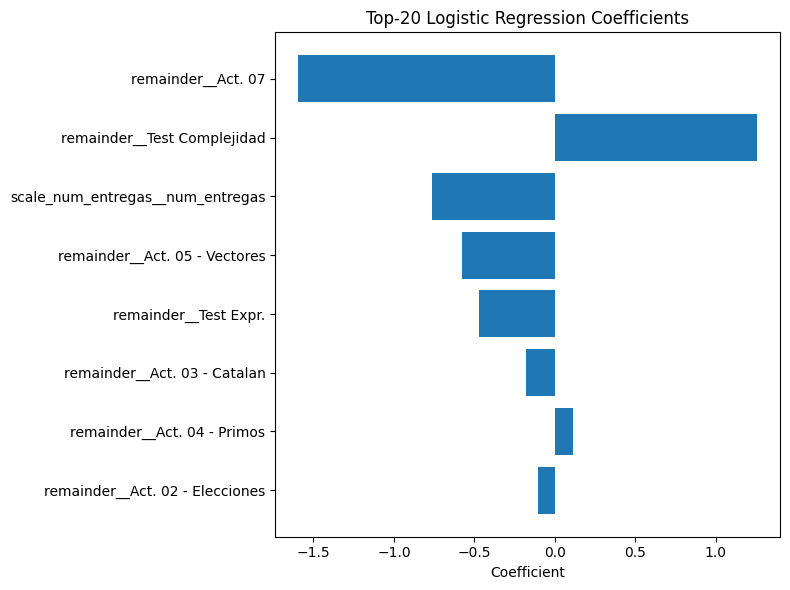

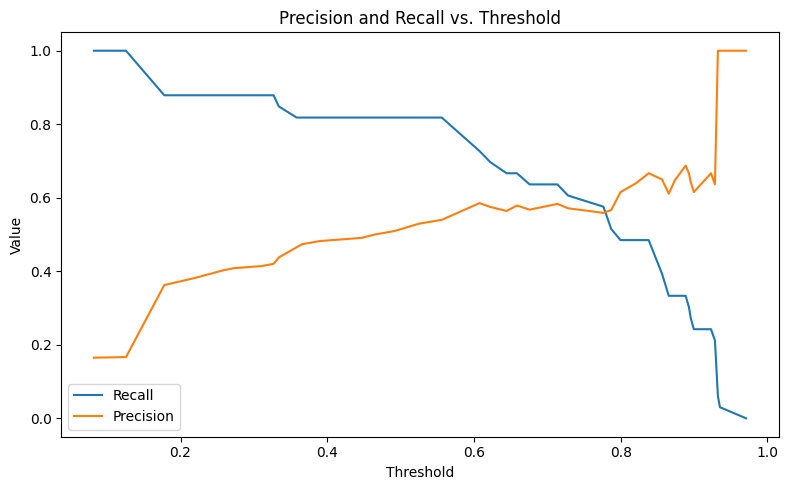

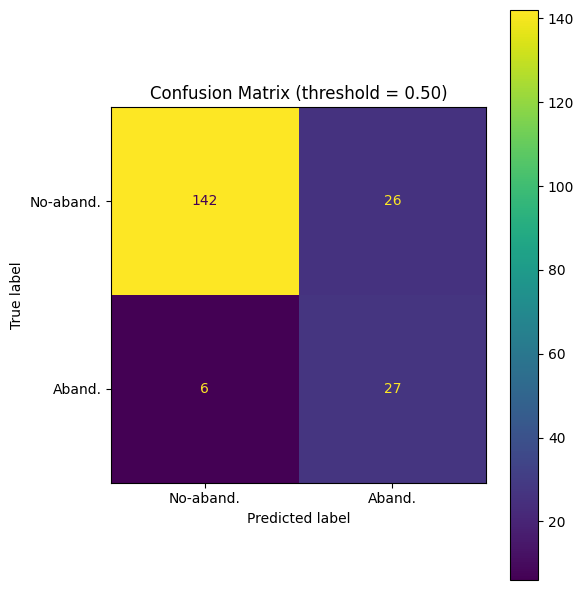

In [56]:
# Visualizar coeficientes de la regresión logística,
# Curva PR con umbrales y matriz de confusión

import joblib, os
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.metrics import (
    precision_recall_curve, average_precision_score,
    confusion_matrix, ConfusionMatrixDisplay
)

# --- 1. Cargar modelo y datos ---------------------------------------------
pipeline = joblib.load(os.path.join("models", "logreg.pkl"))
# Se asume que X, y están ya en memoria

y_prob = pipeline.predict_proba(X)[:, 1]
y_pred = (y_prob >= 0.5).astype(int)

# --- 2. Coeficientes -------------------------------------------------------
feature_names = pipeline.named_steps["pre"].get_feature_names_out()
coef = pipeline.named_steps["clf"].coef_[0]
coef_df = (
    pd.DataFrame({"feature": feature_names, "coef": coef})
      .assign(abs_coef=lambda df: df.coef.abs())
      .sort_values("abs_coef", ascending=False)
)

print("LR Coefficients:")
display(coef_df[["feature", "coef"]])

# Gráfico Top‑20 coeficientes
plt.figure(figsize=(8,6))
plt.barh(coef_df.head(20)["feature"][::-1],
         coef_df.head(20)["coef"][::-1])
plt.xlabel("Coefficient")
plt.title("Top‑20 Logistic Regression Coefficients")
plt.tight_layout()
plt.show()
# --- 3. Curva Precision‑Recall con umbrales -------------------------------
precision, recall, thresholds = precision_recall_curve(y, y_prob)
ap = average_precision_score(y, y_prob)

fig, ax2 = plt.subplots(1, 1, figsize=(8, 5))

# Precision & Recall vs Threshold
# note thresholds aligns with precision[1:], recall[1:]
ax2.plot(thresholds, recall[1:], label="Recall")
ax2.plot(thresholds, precision[1:], label="Precision")
ax2.set_xlabel("Threshold")
ax2.set_ylabel("Value")
ax2.set_title("Precision and Recall vs. Threshold")
ax2.legend()

plt.tight_layout()
plt.show()

# --- 4. Matriz de confusión (threshold = 0.5) -----------------------------
cm = confusion_matrix(y, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=["No‑aband.", "Aband."])
fig, ax = plt.subplots(figsize=(6,6))
disp.plot(ax=ax)
plt.title("Confusion Matrix (threshold = 0.50)")
plt.tight_layout()
plt.show()



# Probar métricas con umbral 0.6 

Metrics at threshold = 0.6
F1-score : 0.651
Precision: 0.540
Recall   : 0.818
ROC AUC  : 0.865


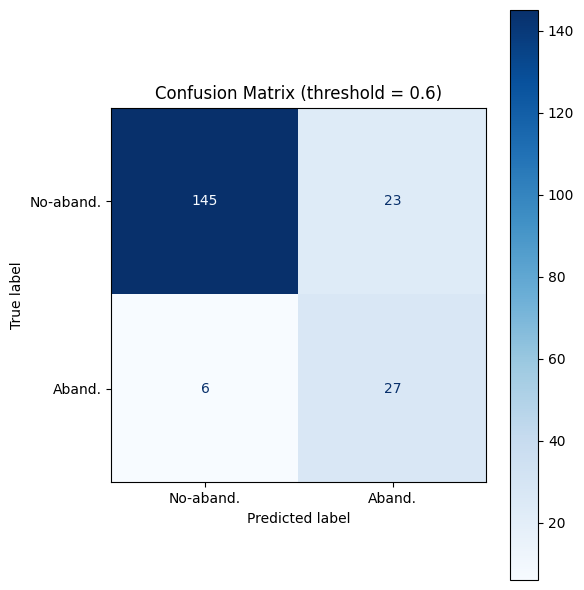

In [57]:
# ============================================================
# Métricas y matriz de confusión para threshold = 0.6
# ============================================================
import os, joblib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    f1_score, precision_score, recall_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay
)

# 1) Cargar pipeline de regresión logística
model = joblib.load(os.path.join("models", "logreg.pkl"))

# 2) Calcular probabilidades y predicciones con umbral 0.6
y_prob = model.predict_proba(X)[:, 1]
threshold = 0.6
y_pred_thr = (y_prob >= threshold).astype(int)

# 3) Calcular métricas
f1      = f1_score(y, y_pred_thr)
precision = precision_score(y, y_pred_thr)
recall  = recall_score(y, y_pred_thr)
roc_auc = roc_auc_score(y, y_prob)  # AUC no cambia con el threshold

print(f"Metrics at threshold = {threshold}")
print(f"F1-score : {f1:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall   : {recall:.3f}")
print(f"ROC AUC  : {roc_auc:.3f}")

# 4) Mostrar matriz de confusión
cm = confusion_matrix(y, y_pred_thr)
disp = ConfusionMatrixDisplay(cm, display_labels=["No-aband.", "Aband."])
fig, ax = plt.subplots(figsize=(6,6))
disp.plot(ax=ax, cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix (threshold = {threshold})")
plt.tight_layout()
plt.show()
